In [1]:
import sys

sys.path.append("..")

In [2]:
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.utils import draw_segmentation_masks
from tqdm import tqdm
from src.data import DetectionDataModule
from src.models import get_maskrcnn

In [3]:
def show_image(image: torch.Tensor):
    plt.imshow(image.numpy().transpose(1, 2, 0))
    plt.axis("off")

In [4]:
transform = A.Compose([A.ToFloat(), ToTensorV2()])

In [5]:
with open("../data/val_images_ds1.txt") as fin:
    val_images = fin.read().split()
val_images[:5]

['f1af97caff9d',
 'b5e5e2970afb',
 'b1374d055915',
 'cb96f7b681f8',
 '2136df4a5aeb']

In [6]:
dm = DetectionDataModule(
    root="../data/hubmap",
    target_class="blood_vessel",
    dataset_ids=[1],
    train_transform=transform,
    val_transform=transform,
    val_images=val_images
)
dm.prepare_data()
dm.setup("")

In [7]:
def draw_masks(image, masks, scores=None, min_score=0.1):
    if scores is None:
        scores = torch.ones((len(masks),))
    scores = scores.numpy()
    n = (scores > min_score).sum()
    colors = [(int(round(255 * score)),
               int(round(255 * (1 - score))),
               0)
              for score in scores[:n]]
    if not isinstance(masks, torch.Tensor):
        masks = torch.stack(masks, 0)
    else:
        masks = masks.squeeze(1).round().to(torch.uint8)
    return draw_segmentation_masks(
        image=(image * 255).round().clip(0, 255).to(torch.uint8),
        masks=masks[:n].to(torch.bool),
        colors=colors,
        alpha=0.5
    )

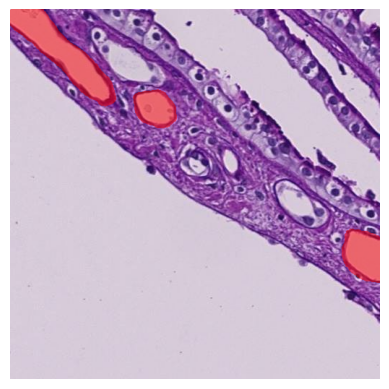

In [8]:
image, masks = dm.train_dset[42]
draw = draw_masks(image, masks)
show_image(draw)

In [9]:
model = get_maskrcnn(pretrained=False)
model.load_state_dict(torch.load("../models/cur_best/mask_r-cnn.pth",
                                 map_location="cpu"))
model = model.to("cuda")
model.eval();

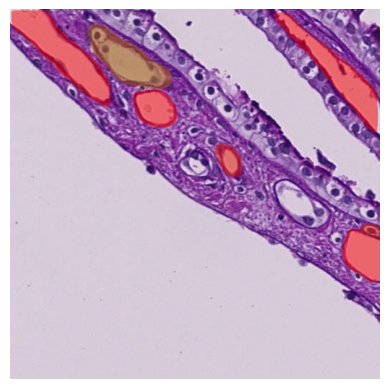

In [10]:
with torch.no_grad():
    preds = model(image.unsqueeze(0).to("cuda"))[0]
draw = draw_masks(image, preds["masks"].cpu(), preds["scores"].cpu(), min_score=0.5)
show_image(draw)

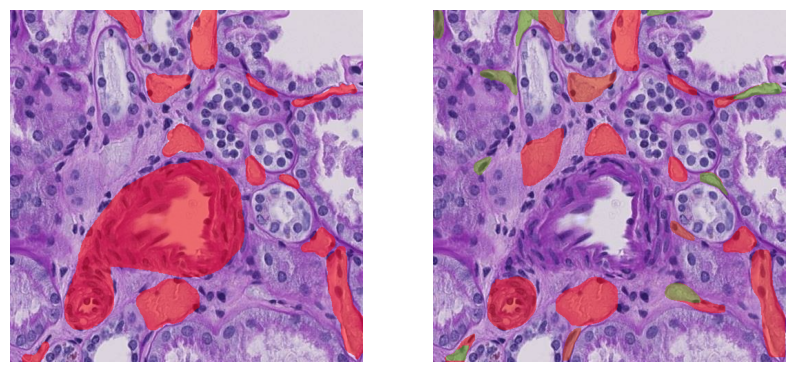

In [11]:
image, masks = random.choice(dm.val_dset)
with torch.no_grad():
    preds = model(image.unsqueeze(0).to("cuda"))[0]

d1 = draw_masks(image, masks)
d2 = draw_masks(image, preds["masks"].cpu(), preds["scores"].cpu(), 0.3)
plt.figure(figsize=(10, 5))
plt.subplot(121)
show_image(d1)
plt.subplot(122)
show_image(d2)

In [12]:
def process_mask(mask: torch.Tensor, ks: int = 11, n_iter: int = 2
                 ) -> torch.Tensor:
    assert mask.ndim == 2 and mask.dtype == torch.uint8
    mask = mask.detach().cpu().numpy()
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ks, ks))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=n_iter)
    return torch.tensor(mask)

In [13]:

def get_map(ks, n_iter) -> dict:
    mean_ap = MeanAveragePrecision(iou_type="segm")
    predictions = []
    targets = []

    for batch in tqdm(dm.val_dataloader()):
        images, gt = batch
        bs = len(images)
        with torch.no_grad():
            images = torch.stack([img.to("cuda") for img in images])
            preds = model(images)
            for pred in preds:
                pred["masks"] = pred["masks"].round().to(torch.uint8).squeeze(1)
                for k, v in pred.items():
                    pred[k] = v.cpu()
                if ks and n_iter:
                    pred["masks"] = torch.stack([process_mask(mask, ks, n_iter)
                                                for mask in pred["masks"]])
        for i in range(bs):
            preds[i] = {k: v.cpu() for k, v in preds[i].items()}
        predictions.extend(preds)
        targets.extend(gt)

    return mean_ap(predictions, targets)

get_map(None, None)

100%|██████████| 21/21 [00:07<00:00,  2.81it/s]


{'map': tensor(0.3410),
 'map_50': tensor(0.6788),
 'map_75': tensor(0.3138),
 'map_small': tensor(0.2169),
 'map_medium': tensor(0.4448),
 'map_large': tensor(0.5267),
 'mar_1': tensor(0.0671),
 'mar_10': tensor(0.3508),
 'mar_100': tensor(0.4837),
 'mar_small': tensor(0.3743),
 'mar_medium': tensor(0.5762),
 'mar_large': tensor(0.6167),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}

In [14]:
results = {}
for ks in (3, 5, 7, 9, 11, 13):
    for n_iter in (1, 2, 5, 10):
        scores = get_map(ks, n_iter)
        results[(ks, n_iter)] = scores

100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


In [15]:
n_iter = np.array([1, 2, 5, 10])
ks = np.array([3, 5, 7, 9, 11, 13])
mean_ap_cmap = np.zeros((len(n_iter), len(ks)))
for i, n in enumerate(n_iter):
    for j, ksize in enumerate(ks):
        mean_ap_cmap[i, j] = results[(ksize, n)]["map"]

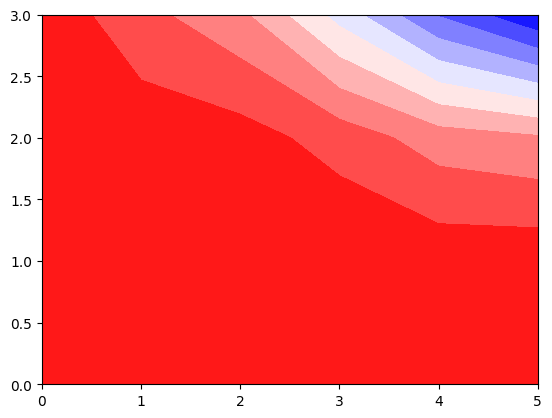

In [16]:
plt.contourf(np.exp(mean_ap_cmap - 0.3410), cmap=plt.cm.bwr, levels=10)

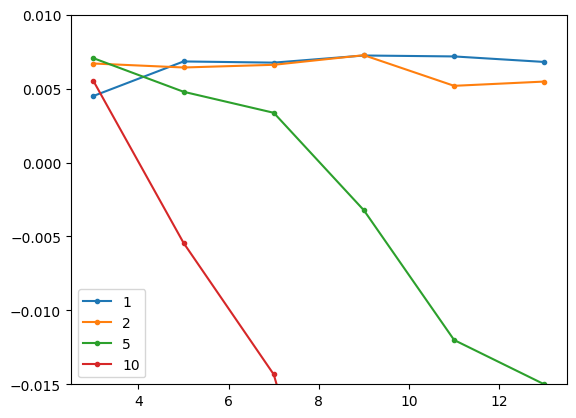

In [17]:
plt.figure()
for i, row in enumerate(mean_ap_cmap):
    plt.plot(ks, row - 0.341, label=n_iter[i], marker='.')
plt.ylim(-0.015, 0.01)
plt.legend()

In [18]:
results[(9, 1)]

{'map': tensor(0.3482),
 'map_50': tensor(0.6851),
 'map_75': tensor(0.3269),
 'map_small': tensor(0.2213),
 'map_medium': tensor(0.4542),
 'map_large': tensor(0.5275),
 'mar_1': tensor(0.0679),
 'mar_10': tensor(0.3571),
 'mar_100': tensor(0.4948),
 'mar_small': tensor(0.3865),
 'mar_medium': tensor(0.5865),
 'mar_large': tensor(0.6250),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}